# Health-Care-Data-Analysis

### - Modeling & Evaluating model performance (1) -

## Load Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


from sklearn.preprocessing import StandardScaler
# 데이터 분할: train, test
from sklearn.model_selection import train_test_split
# 로지스틱 회귀
from statsmodels.api import Logit
# 평가 함수
from sklearn.metrics import accuracy_score
# confusion matrix
from sklearn.metrics import confusion_matrix

from sklearn.tree import export_graphviz
# 의사결정트리
from sklearn.tree import DecisionTreeClassifier
# 랜덤포레스트
from sklearn.ensemble import RandomForestClassifier
# 그래디언트 부스트
from sklearn.ensemble import GradientBoostingClassifier
# grid search
from sklearn.model_selection import GridSearchCV

# 모델 성능 평가 : F1 Score, ROC_Curve, AUC
from sklearn.metrics import f1_score,  roc_curve, auc
import matplotlib.pyplot as plt

In [2]:
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus']=False

In [3]:
import ipywidgets as widgets
from IPython.display import display
from IPython.display import set_matplotlib_formats

In [4]:
# 폰트
plt.rc("font",family = "Malgun Gothic")

# 선명하게 글씨체를 출력시킬때 
set_matplotlib_formats('retina')

# 음수 값 출력
plt.rc('axes',unicode_minus=False)

# 최대 출력 column수 지정 
pd.options.display.max_columns = 100 

In [5]:
df_raw = pd.read_csv('health_real_fin.csv', encoding='utf-8')
df_raw['성별'] = df_raw['성별'].astype('object')
df_raw['흡연상태'] = df_raw['흡연상태'].astype('object')
df_raw['단백뇨'] = df_raw['단백뇨'].astype('object')

### preprocessing before modeling

In [6]:
# rename
df_raw['식전혈당_공복혈당'] = df_raw['식전혈당(공복혈당)']
df_raw.drop('식전혈당(공복혈당)', axis=1, inplace=True)

df_raw['혈청지오티_AST'] = df_raw['(혈청지오티)AST']
df_raw.drop('(혈청지오티)AST', axis=1, inplace=True)

df_raw['혈청지오티_ALT'] = df_raw['(혈청지오티)ALT']
df_raw.drop('(혈청지오티)ALT', axis=1, inplace=True)

In [7]:
df_raw['BMI']=df_raw['체중']/(df_raw['신장']/100) ** 2
df_raw['BMI']=df_raw['BMI'].astype('float64')
df_raw['BMI'] = df_raw['BMI'].round(1)

In [8]:
df_raw.drop(['시도코드', '시력(좌)', '시력(우)', '청력(좌)', '청력(우)', '총콜레스테롤', '트리글리세라이드','연령대',
             '신장', '체중', '구강검진_수검', '가입자일련번호', '실명', '복부비만', '고지혈증', '고혈압', '고혈압_k',
             '총콜레스테롤', '총콜레스테롤_div', '공복혈당', '당뇨', '당뇨_k', '당뇨_표적장기손상', '빈혈', '빈혈_k', 'whtr', 'whtr_k',
             '도시', 'bmi', 'bmi_div_k', 'bmi_div', 'non-HDL', 'CRF', '대사증후군_k', '혈청크레아티닌_진단', 'eGFR',
             'GFR', 'eGFR_진단', '신장질환', 'risk_factor', '심혈관질환', '단백뇨', '단백뇨_k', 'ALT구분', 'AST구분', 
             '감마지티피구분', 'AST/ALT비율', 'GTP/ALT비율', '알코올성간질환여부', '기초대사량', '위험도_허리둘레', 
             '복합상대위험도', '평균절대위험도', '조정복합상대위험도', '절대위험도', '심뇌혈관나이', '교정복합상대위험도',
             '교정절대위험도', '교정심뇌혈관나이'], axis=1, inplace=True)

In [9]:
df_raw.columns

Index(['허리둘레', '수축기혈압', '이완기혈압', 'HDL콜레스테롤', 'LDL콜레스테롤', '혈색소', '요단백',
       '혈청크레아티닌', '감마지티피', '흡연상태', '성별', 'BMI', '대사증후군', '나이', '식전혈당_공복혈당',
       '혈청지오티_AST', '혈청지오티_ALT'],
      dtype='object')

## 대사증후군 예측 모델

In [10]:
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.datasets import dump_svmlight_file
from sklearn.externals import joblib
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

C:\Users\Gyulee\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [11]:
df_raw_train, df_raw_test=train_test_split(df_raw, test_size=0.3, random_state=1234)
print("train data size:{}".format(df_raw_train.shape))
print("test data size:{}".format(df_raw_test.shape))

train data size:(48527, 17)
test data size:(20798, 17)


In [12]:
df_raw_train_y=df_raw_train['대사증후군']
df_raw_train_x=df_raw_train.drop('대사증후군', axis=1, inplace=False)

#### Logistic Reg

In [13]:
# 로지스틱 회귀

log_model = Logit.from_formula("""대사증후군~허리둘레+수축기혈압+이완기혈압+식전혈당_공복혈당+HDL콜레스테롤+LDL콜레스테롤+혈청크레아티닌+혈청지오티_AST+혈청지오티_ALT+감마지티피+C(흡연상태)+C(성별)+나이+BMI""", df_raw_train)

log_result=log_model.fit(method='bfgs')
print(log_result.summary())

         Current function value: 0.346216
         Iterations: 35
         Function evaluations: 41
         Gradient evaluations: 41
                           Logit Regression Results                           
Dep. Variable:                  대사증후군   No. Observations:                48527
Model:                          Logit   Df Residuals:                    48511
Method:                           MLE   Df Model:                           15
Date:                Sun, 24 Nov 2019   Pseudo R-squ.:                  0.4268
Time:                        15:57:22   Log-Likelihood:                -16801.
converged:                      False   LL-Null:                       -29308.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -6.3004      0.222    -28.354      0.000      -6.736    

C:\Users\Gyulee\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [14]:
y_pred=log_result.predict(df_raw_test)
# 0과 1의 값을 가진 class로 변환
y_pred_class=(y_pred>0.5).astype(int)
y_pred_class.head()

30902    0
1706     0
602      0
17345    0
31477    0
dtype: int32

In [15]:
print("Accuracy:{0:.3f}\n".format(accuracy_score(df_raw_test['대사증후군'], y_pred_class)))
print("Confusion Matrix:\n{}".format(confusion_matrix(df_raw_test['대사증후군'], y_pred_class)))

Accuracy:0.850

Confusion Matrix:
[[13593  1255]
 [ 1874  4076]]


In [16]:
df_raw_y=df_raw['대사증후군']
df_raw_x=df_raw.drop('대사증후군', axis=1, inplace=False)

df_temp_x, df_test_x, df_temp_y, df_test_y=train_test_split(df_raw_x, df_raw_y, test_size=0.3, random_state=1234)

df_train_x, df_validation_x, df_train_y, df_validation_y=train_test_split(df_temp_x, df_temp_y, test_size=0.4, random_state=1234)

In [17]:
fpr, tpr, thresholds=roc_curve(df_test_y,y_pred)
roc_auc=auc(fpr,tpr)

In [18]:
roc_auc

0.9077256026332947

In [19]:
# f1_score(df_test_y, y_pred)

In [20]:
print("train data X size:{}".format(df_train_x.shape))
print("train data Y size:{}".format(df_train_y.shape))
print("validation data X size:{}".format(df_validation_x.shape))
print("validation data Y size:{}".format(df_validation_y.shape))
print("test data X size:{}".format(df_test_x.shape))
print("test data Y size:{}".format(df_test_y.shape))

train data X size:(29116, 16)
train data Y size:(29116,)
validation data X size:(19411, 16)
validation data Y size:(19411,)
test data X size:(20798, 16)
test data Y size:(20798,)


#### DT

In [21]:
# 의사결정나무

tree_final = DecisionTreeClassifier(max_depth = 9, min_samples_split = 36, min_samples_leaf = 12)
tree_final.fit(df_train_x, df_train_y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=9,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=12, min_samples_split=36,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [22]:
validation_pred = tree_final.predict(df_validation_x)
print('Accuracy on training set:{0:.3f}\n'.format(tree_final.score(df_train_x, df_train_y)))
print('Accuracy on validation set:{0:.3f}\n'.format(tree_final.score(df_validation_x, df_validation_y)))
print('Confusion matrix:\n{}'.format(confusion_matrix(df_validation_y, validation_pred)))


Accuracy on training set:0.931

Accuracy on validation set:0.921

Confusion matrix:
[[13405   377]
 [ 1156  4473]]


In [23]:
y_pred = tree_final.predict(df_test_x)
print('Accuracy:{0:.3f}\n'.format(tree_final.score(df_test_x, df_test_y)))
print('Confusion matrix:\n{}'.format(confusion_matrix(df_test_y, y_pred)))


Accuracy:0.920

Confusion matrix:
[[14399   449]
 [ 1224  4726]]


In [24]:
fpr, tpr, thresholds=roc_curve(df_test_y,y_pred)
roc_auc=auc(fpr,tpr)


In [25]:
roc_auc

0.8820229756773399

In [26]:
f1_score(df_test_y, y_pred) 

0.84961797752809

In [27]:
# 의사결정 나무 변수중요도 확인하기
v_feature_name=df_train_x.columns

In [28]:
df_importance = pd.DataFrame()
df_importance['Feature'] = v_feature_name
df_importance['Importance'] = tree_final.feature_importances_

In [29]:
df_importance.sort_values('Importance', ascending = False, inplace = True)
df_importance.round(3)

,Feature,Importance
0,허리둘레,0.387
13,식전혈당_공복혈당,0.194
3,HDL콜레스테롤,0.190
1,수축기혈압,0.154
8,감마지티피,0.031
2,이완기혈압,0.027
4,LDL콜레스테롤,0.004
5,혈색소,0.004
11,BMI,0.003
14,혈청지오티_AST,0.001


Text(0, 0.5, '설명변수')

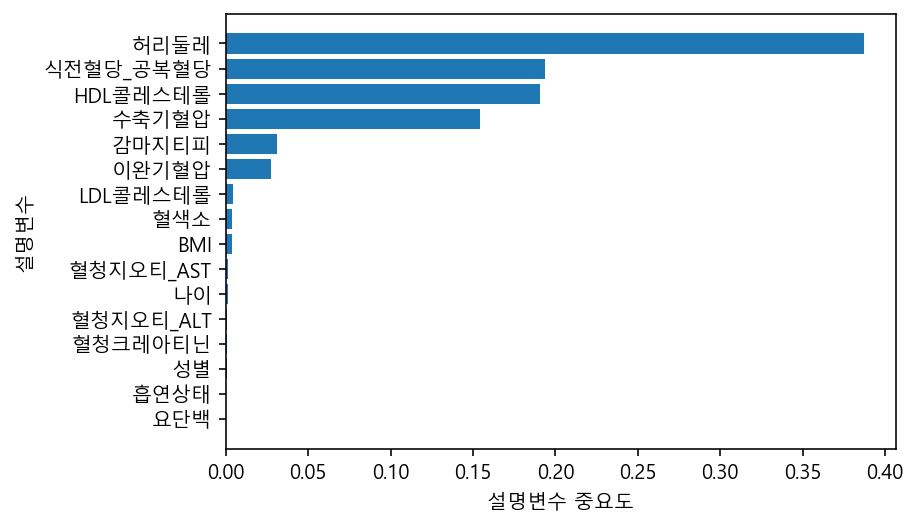

In [30]:
df_importance.sort_values('Importance', ascending =True, inplace = True)
coordinates = range(len(df_importance))
plt.barh(y = coordinates, width = df_importance['Importance'])
plt.yticks(coordinates, df_importance['Feature'])
plt.xlabel('설명변수 중요도')
plt.ylabel('설명변수')

#### RF

In [31]:
# 랜덤 포레스트

rf_final = RandomForestClassifier(n_estimators = 20, max_depth = 7, min_samples_split = 14, min_samples_leaf = 6, random_state = 1234)
rf_final.fit(df_train_x, df_train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=7, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=14,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=1234,
                       verbose=0, warm_start=False)

In [32]:
validation_pred = rf_final.predict(df_validation_x)
print('Accuracy on training set:{0:.3f}\n'.format(rf_final.score(df_train_x, df_train_y)))
print('Accuracy on validation set:{0:.3f}\n'.format(rf_final.score(df_validation_x, df_validation_y)))
print('Confusion matrix:\n{}'.format(confusion_matrix(df_validation_y, validation_pred)))

Accuracy on training set:0.926

Accuracy on validation set:0.919

Confusion matrix:
[[13353   429]
 [ 1146  4483]]


In [33]:
y_pred = rf_final.predict(df_test_x)
print('Accuracy:{0:.3f}\n'.format(rf_final.score(df_test_x, df_test_y)))
print('Confusion matrix:\n{}'.format(confusion_matrix(df_test_y, y_pred)))

Accuracy:0.921

Confusion matrix:
[[14414   434]
 [ 1215  4735]]


In [34]:
fpr, tpr, thresholds=roc_curve(df_test_y,y_pred)
roc_auc=auc(fpr,tpr)

In [35]:
roc_auc

0.883284396732831

In [36]:
f1_score(df_test_y, y_pred)

0.851695296339599

In [37]:
v_feature_name = df_train_x.columns

In [38]:
df_importance = pd.DataFrame()
df_importance['Feature'] = v_feature_name
df_importance['Importance'] = rf_final.feature_importances_

In [39]:
df_importance.sort_values('Importance', ascending = False, inplace = True)
df_importance.round(3)

,Feature,Importance
3,HDL콜레스테롤,0.265
0,허리둘레,0.223
13,식전혈당_공복혈당,0.179
1,수축기혈압,0.155
8,감마지티피,0.059
11,BMI,0.052
2,이완기혈압,0.035
15,혈청지오티_ALT,0.012
5,혈색소,0.005
12,나이,0.004


In [40]:
df_importance.sort_values('Importance', ascending =True, inplace = True)
coordinates = range(len(df_importance))

Text(0, 0.5, '설명변수')

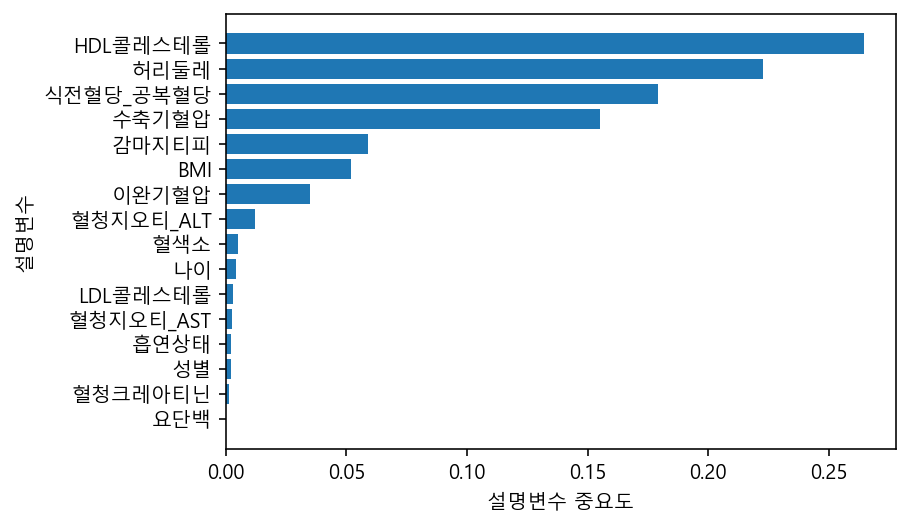

In [41]:
plt.barh(y = coordinates, width = df_importance['Importance'])
plt.yticks(coordinates, df_importance['Feature'])
plt.xlabel('설명변수 중요도')
plt.ylabel('설명변수')


#### GBM

In [42]:
# 그래디언트 부스팅

gb_final=GradientBoostingClassifier(min_samples_leaf=30, max_depth=4, n_estimators=300, learning_rate=0.15, random_state=1234)
gb_final.fit(df_train_x, df_train_y)

y_pred=gb_final.predict(df_test_x)

In [43]:
print("Accuracy on training set:{:.3f}".format(gb_final.score(df_train_x, df_train_y)))
print("Accuracy on test set:{:.3f}".format(gb_final.score(df_test_x, df_test_y)))

print("Confusion matrix:\n{}".format(confusion_matrix(df_test_y, y_pred)))

Accuracy on training set:0.961
Accuracy on test set:0.921
Confusion matrix:
[[14247   601]
 [ 1050  4900]]


In [44]:
y_pred =gb_final.predict(df_test_x)
print('Accuracy:{0:.3f}\n'.format(rf_final.score(df_test_x, df_test_y)))
print('Confusion matrix:\n{}'.format(confusion_matrix(df_test_y, y_pred)))

Accuracy:0.921

Confusion matrix:
[[14247   601]
 [ 1050  4900]]


In [45]:
fpr, tpr, thresholds=roc_curve(df_test_y, y_pred)
roc_auc=auc(fpr, tpr)

roc_auc

0.8915262899340771

In [46]:
f1_score(df_test_y, y_pred)

0.8558204523622391

#### XGBoost

In [47]:
# xgboost

import xgboost as xgb

In [48]:
X_train, X_test, y_train, y_test = train_test_split(df_raw_x, df_raw_y, test_size=0.3, random_state=1234)
eta = 0.05
max_depth = 12
min_child_weight = 2
num_boost_round = 500
colsample_bytree = 0.8
subsample = 0.8
param = {
    'booster': 'gbtree',
    'objective': 'binary:hinge',
    'eval_metric': 'error',
    'eta': eta,
    'max_depth': max_depth,
    'subsample': subsample,
    'colsample_bytree': colsample_bytree,
    'min_child_weight': min_child_weight,
    'silent': 1,
    'seed': 1234,
    }


In [49]:
X_trn = X_train.as_matrix()
Y_trn = y_train.as_matrix()
X_tet = X_test.as_matrix()
Y_tet = y_test.as_matrix()
features = df_raw_x.columns.values.tolist()
dtrn = xgb.DMatrix(X_trn, label=Y_trn, feature_names=features)
dtet = xgb.DMatrix(X_tet, label=Y_tet, feature_names=features)
watch_list = [(dtrn, 'train'), (dtet, 'test')]

model = xgb.train(param, dtrn, num_boost_round, evals=watch_list,early_stopping_rounds=10)

[0]	train-error:0.707977	test-error:0.713915
Multiple eval metrics have been passed: 'test-error' will be used for early stopping.

Will train until test-error hasn't improved in 10 rounds.
[1]	train-error:0.707977	test-error:0.713915


C:\Users\Gyulee\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
C:\Users\Gyulee\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\Users\Gyulee\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Gyulee\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


[2]	train-error:0.707977	test-error:0.713915
[3]	train-error:0.707977	test-error:0.713915
[4]	train-error:0.707977	test-error:0.713915
[5]	train-error:0.707977	test-error:0.713915
[6]	train-error:0.707977	test-error:0.713915
[7]	train-error:0.707977	test-error:0.713915
[8]	train-error:0.707977	test-error:0.713915
[9]	train-error:0.707977	test-error:0.713915
[10]	train-error:0.255136	test-error:0.280412
[11]	train-error:0.187009	test-error:0.214203
[12]	train-error:0.157809	test-error:0.184922
[13]	train-error:0.135966	test-error:0.162275
[14]	train-error:0.122777	test-error:0.155159
[15]	train-error:0.10829	test-error:0.142225
[16]	train-error:0.096235	test-error:0.135878
[17]	train-error:0.085334	test-error:0.128233
[18]	train-error:0.074804	test-error:0.122127
[19]	train-error:0.066252	test-error:0.11703
[20]	train-error:0.059822	test-error:0.112222
[21]	train-error:0.053867	test-error:0.109674
[22]	train-error:0.048344	test-error:0.10626
[23]	train-error:0.044058	test-error:0.102462

In [50]:
preds = model.predict(dtet, ntree_limit=model.best_ntree_limit)
# best_preds = np.asarray([np.argmax(line) for line in preds])

print("Numpy array precision:", precision_score(y_test, preds, average='macro'))
print('Confusion Matrix: \n{}'.format(confusion_matrix(y_test, preds)))

Numpy array precision: 0.9096171305203576
Confusion Matrix: 
[[14173   675]
 [  938  5012]]
